In [18]:
# Load packages; may take a few seconds to run.
using Gen
using PyPlot
using StatsBase
using Statistics
import Random

In [4]:
second(x) = x[2] #used to pull logweight from tuple of (trace, logweight)
;

## Text to introduce AIDE here?

(needs to fit in with rest of lecture, so I won't write it)

In [5]:
# Compare the distribution of return values of two generative functions, using AIDE
# Returns an unbiased estimate of an upper bound on the symmetrized KL divergence
#    between f and g.
function AIDE_compare(
        f, g, #generative functions to compare. 
            #Both should return the (comparable) "output" value of interest.
        
        input, #any input to generative functions; must be same for both of them.
        
        ret_to_f, ret_to_g, #Functions. Input: return value (from f or g)
                                #Output: constraints for one generative, 
                                #sufficient to guarantee same return value
        
        Nf, Ng, #Number of traces to draw from each generative
        Mf, Mg  #Number of runs of each to use to estimate a given generative's score of a trace
    )
    cm = choicemap()
    f_vals = [Gen.get_retval(generate(f, input, cm)[1]) for i in 1:Nf]
    g_vals = [Gen.get_retval(generate(g, input, cm)[1]) for i in 1:Ng]
    
    f_scores_of_g = [mean([second(generate(f, input, ret_to_f(v))) for j in 1:Mf]) 
                        for v in g_vals] #One average log density from f for each draw of g
    g_scores_of_f = [mean([second(generate(g, input, ret_to_g(v))) for j in 1:Mf])
                        for v in f_vals] #(as above)  Note that we're ignoring stdev of the...
    f_scores_of_f = [mean([second(generate(f, input, ret_to_f(v))) for j in 1:Mf]) 
                        for v in f_vals] #(as above)  ...score estimation process, because...
    g_scores_of_g = [mean([second(generate(g, input, ret_to_g(v))) for j in 1:Mf]) 
                        for v in g_vals] #(as above)  ...it's more hassle than it's worth.
    
    KLfg = mean(f_scores_of_f) - mean(g_scores_of_f)
    KLgf = mean(g_scores_of_g) - mean(f_scores_of_g)
    
    symse2 = (var(f_scores_of_f .- g_scores_of_f; corrected=true)/Nf +  #squared standard error
                var(g_scores_of_g .- f_scores_of_g; corrected=true)/Ng) #(using paired samples)
    
    (KLfg + KLgf, sqrt(symse2)) #tuple of (symmetrized KL hat, standard error thereof)
end
;

## "Coinflip" example

Say we're inferring the parameter of a Bernoulli distribution — the "weightedness" of a "coinflip" — based on a certain number of observations of the outcome. To do Bayesian inference, we need a prior on the parameter $p$; let's say it's distributed uniformly from 0 to 1. Conveniently, the uniform distribution is a special case of the beta distribution — $Beta(1,1)$ — so we can use the following generative model:

In [11]:
@gen function binom_prior(α, β)
    p ~ beta(α, β)
    p
end

@gen function basic_binom(n, α, β)
    p = @trace(binom_prior(α, β))
    h ~ binom(n, p)
    h
end
;

To do inference over this model, we might use importance sampling. In order to be able to use AIDE to evaluate the quality of that inference, we need the inference procedure itself to be a generative function (that returns one sample from the approximate posterior), as follows:

In [12]:
function importance_cond_binom_for(samps) #A factory which constructs an 
                #inference function that uses a given number of samples
    @gen function i_c_b(h, #number of "heads" observed
            n, #number of "coinflips"
            α = 1., β = 1.)
        constraint = choicemap((:h, h))
        logweights = Vector{Float64}(undef, samps)
        ps = Vector{Float64}(undef, samps)
        for s in 1:samps
            p = @trace(binom_prior(α, β),:data => s)
            constraint[:p] = p
            ps[s] = p
            (_, logweights[s]) = generate(basic_binom, (n, α, β), constraint)
                    #in this simple case, this is just a more-complicated way of calling
                        #Distributions.Binomial(...).logpdf. However, this pattern generalizes
                        #better to inference over arbitrary generative functions.
        end
        logweights .-= max(logweights...)
        weights = exp.(logweights)
        weights ./= sum(weights)
        whichOne ~ categorical(weights)
        p = ps[whichOne]
        p
    end
end
;

Let's test that out for 0 heads out of 10 coinflips, using just 5 samples from the prior. Note that we'd intuitively expect most of the posterior to be below 0.1, but with few samples to do importance sampling over, inference appears poor:

In [24]:
Random.seed!(0)

importance_cond_binom_for(5)(0,10)

0.20308731980110925

Hmm... let's graph the output for $h$ heads out of $n$, using different numbers of samples for importance sampling.

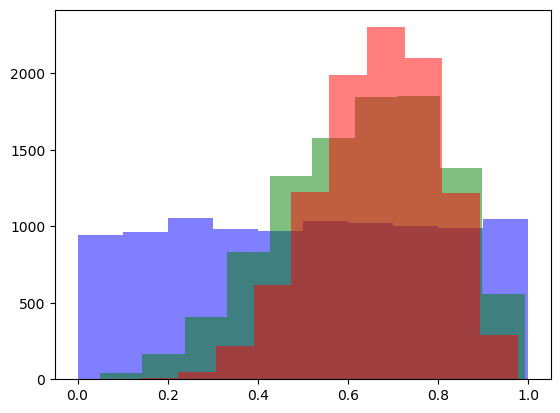

In [37]:
h = 7
n = 10

hist([importance_cond_binom_for(1)(h,n) for i in 1:10000], color="b", alpha =.5) #blue: 1 sample
hist([importance_cond_binom_for(3)(h,n) for i in 1:10000], color="g", alpha =.5) #green: 3 samples
hist([importance_cond_binom_for(20)(h,n) for i in 1:10000], color="r", alpha =.5) #red: 20 samples
;

We also need a gold standard to compare the above inference against. Luckily, because beta and binomial are conjugate distributions, there's an analytic solution:

In [25]:
@gen function analytic_cond_binom(h, n, α = 1., β = 1.)
    p ~ beta(α + h, β + n - h)
    p
end
;

Finally, we need functions to convert the output (of either generative inference function) to a constraint on each of those functions that's sufficient to guarantee that output:

In [14]:
function ret_to_importance_constraint(p)
    constraint = choicemap((:whichOne, 1))
    constraint[:data => 1 => :p] = p
    constraint
end

function ret_to_analytic_constraint(p)
    choicemap((:p, p))
end
;

OK, let's put it all together. Using only a very small number of samples from each generative inference function, let's quickly compare how our estimated KL bound improves as we increase the number of prior samples for the importance sampling method:

In [26]:
Random.seed!(4)

(h,n) = (7,10)

ns = 5
ms = 5

[AIDE_compare(importance_cond_binom_for(i), analytic_cond_binom, #generative functions to compare. Should return the important value.
        (h,n), #any input to generative functions; must be same for both
        ret_to_importance_constraint, ret_to_analytic_constraint, #take a return value from either generative, and produce constraints for one generative
        ns, ns, #Number of traces to draw from each
        ms, ms  #Number of runs of each to use to estimate score
    ) for i in 1:5]

5-element Array{Tuple{Float64,Float64},1}:
 (2.181169155644955, 1.3884452559069211)
 (0.735265026766756, 0.9473137936958114)
 (0.08342677373663299, 0.23139900531179888)
 (-0.10586311583214392, 0.10424573505094893)
 (0.07388414969032553, 0.17965617147700239)

Note that while AIDE's estimated KL (the first element of the tuples) is in expectation an upper bound on KL and thus should be above 0, it's still a stochastic algorithm, and so below zero is possible, as seen above.

Now we've seen that it works, let's do a slightly more computationally-intensive run and turn it into a graph:

In [44]:
ns = 100
ms = 30
max_importance_presamples = 16

results = [AIDE_compare(importance_cond_binom_for(i), analytic_cond_binom, #generative functions to compare. Should return the important value.
        (h,n), #any input to generative functions; must be same for both
        ret_to_importance_constraint, ret_to_analytic_constraint, #take a return value from either generative, and produce constraints for one generative
        ns, ns, #Number of traces to draw from each
        ms, ms  #Number of runs of each to use to estimate score
    ) for i in 1:max_importance_presamples]
;

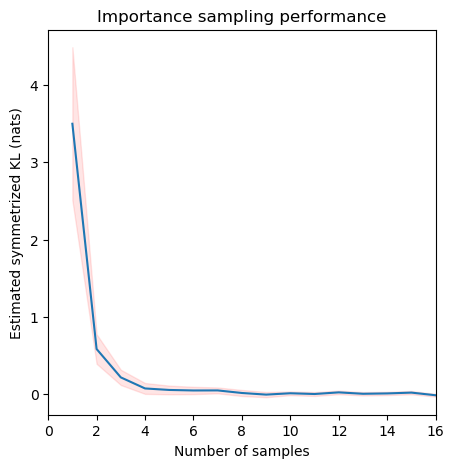

In [45]:
conf_sigs = 1.96

fig = figure("Importance sampling performance",figsize=(5,5))
ax = fig.subplots(1)
ax.set_title("Importance sampling performance")
ax.set_ylabel("Estimated symmetrized KL (nats)")
ax.set_xlabel("Number of samples")
ax.set_xlim((0,max_importance_presamples))
ax.plot(1:max_importance_presamples,[x[1] for x in results])
ax.fill_between(1:max_importance_presamples,[x[1]+x[2]*conf_sigs for x in results],
                    [x[1]-x[2]*conf_sigs for x in results],alpha=.1,color="red")
;

What next? Should we show how this is affected by a misspecified prior (thus doesn't converge to 0)?